In [1]:
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d.axes3d import get_test_data
from mpl_toolkits.mplot3d import Axes3D
from fenics import *
from mshr import *
import numpy as np
from dotenv import load_dotenv
from scipy.ndimage import zoom
from scipy.interpolate import interp1d
import os
set_log_level(30)
# Cargar las variables del archivo .env
load_dotenv()

True

In [2]:
nueva_ruta = os.path.expanduser('~/Drive/Doctorado Erick Serrato/25-I/weak_allee/mu_0')

In [3]:
# Define time parameters
T = float(os.getenv('T'))
dt = float(os.getenv('dt'))
# nb = int(os.getenv('nb'))
save_images = os.getenv('SAVE_IMAGES')
nb = int(os.getenv('nb'))


# Define mesh and space
nodes_in_xaxis=int(os.getenv('nodes_in_xaxis'))
nodes_in_yaxis=int(os.getenv('nodes_in_yaxis'))
space_size=int(os.getenv('space_size'))


os.chdir(nueva_ruta)

In [4]:
def power_spectrum(field_name, t, block):
    """
    Calcula el espectro de potencia 2D en el espacio de Fourier, lo guarda normalizado y lo grafica.
    """
    field_file = f"matrix_{field_name}_{t:.3f}_nb_{block}.txt"
    
    try:
        field = np.loadtxt(field_file, float)
    except Exception as e:
        print(f"Error al cargar el archivo {field_file}: {e}")
        return None, None

    # Transformada de Fourier 2D
    fft_field = np.fft.fft2(field)
    fft_field = np.fft.fftshift(fft_field)
    fft_magnitude = np.abs(fft_field)  # Magnitud de la transformada

    # Normalización del espectro de porm matrix_c_dft_*tencia
    # fft_magnitude /= np.max(fft_magnitude)

    # Guardar el espectro de potencia normalizado
    #dft_file = f"matrix_{field_name}_dft_{t:.3f}_nb_{block}.txt"
    #np.savetxt(dft_file, fft_magnitude, delimiter="\t")
    if block == 1 :
        # Graficar el espectro de potencia
        plt.figure(figsize=(6, 6))
        plt.imshow(np.log1p(fft_magnitude), cmap='inferno', origin='lower')
        plt.colorbar(label="Log Magnitude")
        plt.title(f"Power Spectrum of {field_name} at t={t:.3f}, block={block}")
        plt.xlabel("Frequency X")
        plt.ylabel("Frequency Y")
        plt.savefig(f'power_spectrum_{field_name}_{t}._step_{t:.3f}.png')
        plt.show()

    return field_file, fft_magnitude

In [5]:
def correlation_function_fourier(dft_field1, dft_field2, field1_name, field2_name, step, block):
    """
    Calcula la correlación cruzada en el espacio de Fourier, sin transformarla al espacio real.
    Anula el máximo antes de graficar para mejorar la visualización.
    """
    # Cargar los espectros de Fourier
    #fft1 = np.loadtxt(dft_field1, delimiter="\t")
    #fft2 = np.loadtxt(dft_field2, delimiter="\t")
    fft1 = dft_field1
    fft2 = dft_field2
    
    # Asegurar que tengan el mismo tamaño
    min_shape = (min(fft1.shape[0], fft2.shape[0]), min(fft1.shape[1], fft2.shape[1]))
    fft1 = fft1[:min_shape[0], :min_shape[1]]
    fft2 = fft2[:min_shape[0], :min_shape[1]]

    # Multiplicar en el dominio de Fourier
    correlation_fourier = fft1 * np.conjugate(fft2)

    # Anular el valor máximo
    max_value = np.max(correlation_fourier)
    correlation_fourier[correlation_fourier == max_value] = 0

    # # Graficar
    # plt.figure(figsize=(6, 5))
    # plt.imshow(np.log1p(np.abs(correlation_fourier)), cmap='viridis', origin='lower')
    # plt.colorbar(label='Log Magnitude')
    # plt.title(f'Correlación ({field1_name} vs {field2_name}) Fourier')
    # plt.xlabel('Frecuencia X')
    # plt.ylabel('Frecuencia Y')
    # plt.show()

    return correlation_fourier

In [6]:
def inverse_correlation_fft(centered_correlation, field1_name, field2_name, step, block):
    """
    Revierte el desplazamiento de la función de correlación en Fourier y la transforma de vuelta al espacio real.
    También grafica el campo centrado antes de la transformación inversa.

    Args:
        centered_correlation (np.ndarray): Función de correlación en el espacio de Fourier.1
        field1_name (str): Nombre del primer campo.
        field2_name (str): Nombre del segundo campo.
        step (float): Paso de tiempo.
        block (int): Número de bloque.

    Returns:
        np.ndarray: Transformada inversa de la correlación en el espacio real.
    """
    # Aplicar la transformada inversa de Fourier y centrar el resultado
    inverse_fft = np.fft.ifft2(np.fft.ifftshift(centered_correlation)).real  # Obtener solo la parte real
    inverse_fft = np.fft.fftshift(inverse_fft)  # Recentrar la imagen en el dominio espacial

    # Verificar valores antes de normalizar
    min_val = np.min(inverse_fft)
    max_val = np.max(inverse_fft)
    
    # if max_val - min_val < 1e-8:
    #     raise ValueError("Los valores de la transformada inversa son demasiado pequeños para normalizar.")

    # Normalizar entre 0 y 1
    inverse_fft -= min_val  # Asegurar que el mínimo sea 0
    inverse_fft /= (max_val - min_val)  # Normalizar evitando división por 0

#     # Graficar la transformada inversa centrada
#     plt.figure(figsize=(6, 5))
#     plt.imshow(inverse_fft, cmap='viridis', origin='lower')
#     plt.colorbar(label='Amplitud Normalizada')
#     plt.title(f'Correlación ({field1_name} vs {field2_name}) en espacio real')
#     plt.xlabel('Índice X')
#     plt.ylabel('Índice Y')
#     plt.show()
    
    return inverse_fft


In [7]:
def compute_correlation_length(centered_inverse_fft, dx):
    """
    Calcula la longitud de correlación a partir de un promedio radial de la transformada inversa centrada.
    
    Args:
        centered_inverse_fft (np.ndarray): Transformada inversa de la correlación centrada.
        dx (float): Resolución espacial en unidades físicas.
    
    Returns:
        float: Longitud de correlación en unidades físicas.
    """
    ny, nx = centered_inverse_fft.shape
    x_center, y_center = nx // 2, ny // 2
    
    y, x = np.indices((ny, nx))
    r = np.sqrt((x - x_center)**2 + (y - y_center)**2).astype(int)
    
    r_max = r.max()
    radial_profile = np.zeros(r_max + 1)
    counts = np.zeros(r_max + 1)
    
    for i in range(ny):
        for j in range(nx):
            radial_profile[r[i, j]] += centered_inverse_fft[i, j]
            counts[r[i, j]] += 1
    
    radial_profile /= np.where(counts == 0, 1, counts)
    
    max_value = radial_profile[0]
    threshold = max_value / np.e
    correlation_length_pixels = np.argmax(radial_profile < threshold)
    
    correlation_length_real = correlation_length_pixels * dx  # Conversión a unidades físicas
    
    # print('Longitud de correlación en píxeles:', correlation_length_pixels)
    print('Longitud de correlación en unidades reales:', correlation_length_real)
    
    return correlation_length_real


In [8]:
def save_corr_real_array(array, block, field1_name, field2_name):
    length_corr = np.array(array)
    
    np.savetxt(
        f'corr_length_real_inverse_nb_{block}_{field1_name}_{field2_name}.txt',
        length_corr,
        fmt="%.5f",  # Mayor precisión
        delimiter="\t",
        header="Tiempo\tLongitud_Correlacion"
    )

block= 1 tiempo 0


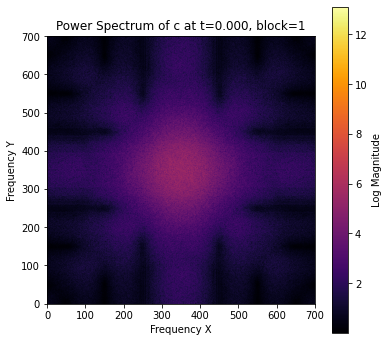

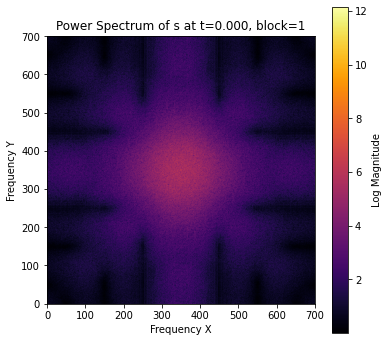

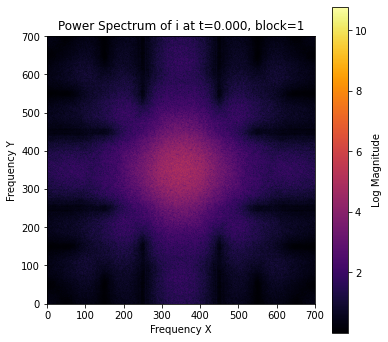

block= 1 tiempo 0.005


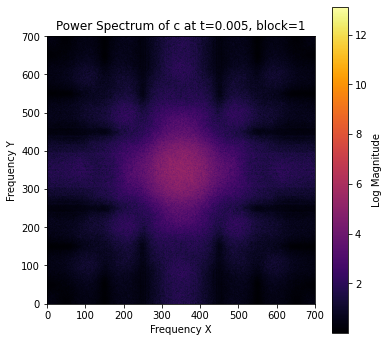

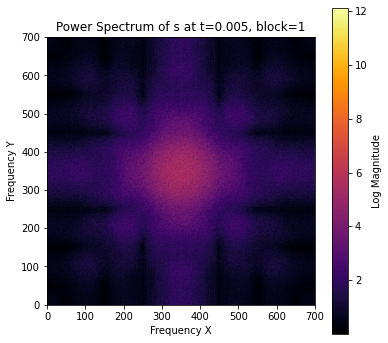

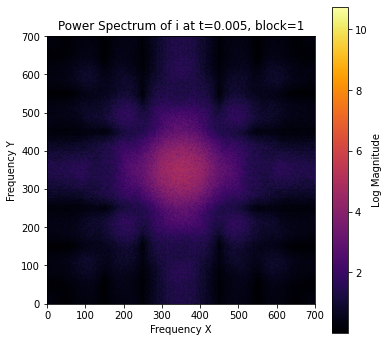

block= 1 tiempo 0.01


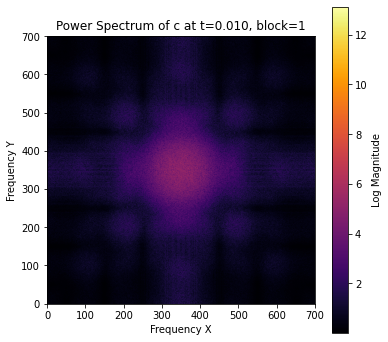

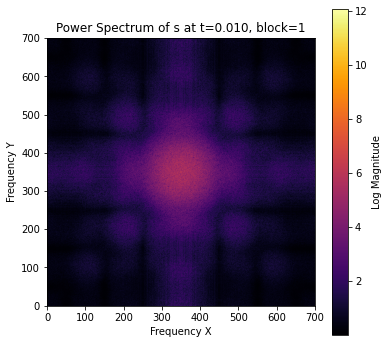

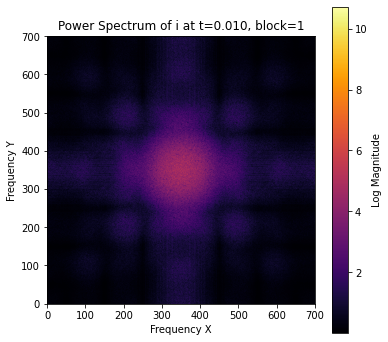

block= 1 tiempo 0.015


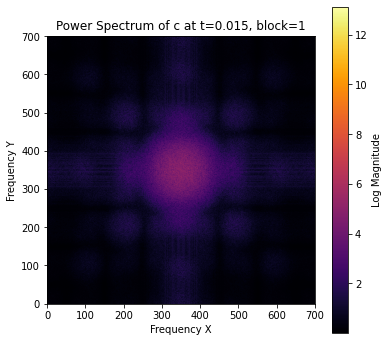

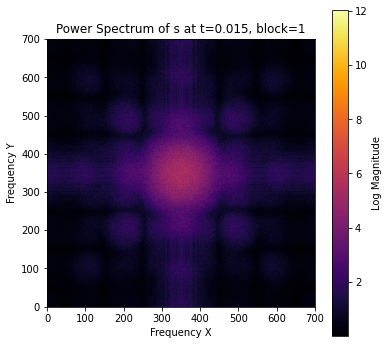

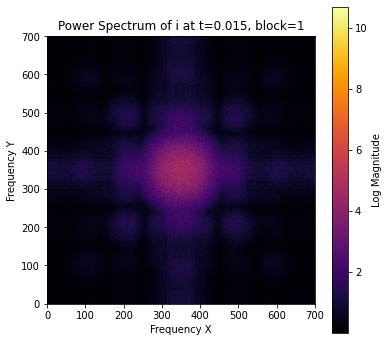

block= 1 tiempo 0.02


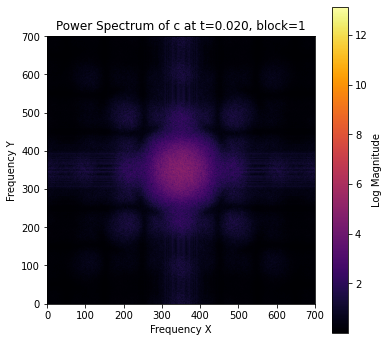

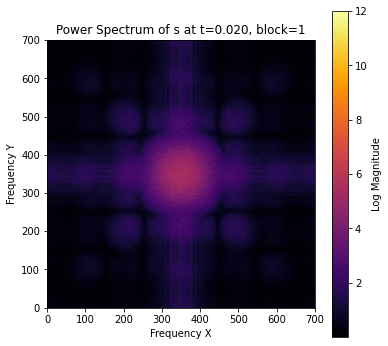

IndexError: index -2 is out of bounds for axis 0 with size 1

In [10]:
# Parámetros de entrada
fieldC_name = "c"  
fieldS_name = "s"  
fieldI_name = "i"  

dx = space_size / nodes_in_xaxis  # Resolución espacial


for block in range(1, nb + 1):

    length_corr_cs = []
    length_corr_ci = []
    length_corr_si = []
    length_corr_cc = []
    length_corr_ss = []
    length_corr_ii = []
    t =  0

    while t <= T:
        print("block=", block, 'tiempo', t)
        # print('Espectro de potencias')
        field_c, dft_field_c = power_spectrum(fieldC_name, t, block)
        field_s, dft_field_s = power_spectrum(fieldS_name, t, block)
        field_i, dft_field_i = power_spectrum(fieldI_name, t, block)

#         print('Calculando funciones de correlación cruzada')
        
#         correlation_func_cs = correlation_function_fourier(dft_field_c, dft_field_s, fieldC_name, fieldS_name, t, block)
#         correlation_func_ci = correlation_function_fourier(dft_field_c, dft_field_i, fieldC_name, fieldI_name, t, block)
#         correlation_func_si = correlation_function_fourier(dft_field_s, dft_field_i, fieldS_name, fieldI_name, t, block)

#         print('Calculando funciones de auto correlación')        
#         correlation_func_ss = correlation_function_fourier(dft_field_c, dft_field_c, fieldC_name, fieldC_name, t, block)
#         correlation_func_cc = correlation_function_fourier(dft_field_s, dft_field_s, fieldS_name, fieldS_name, t, block)
#         correlation_func_ii = correlation_function_fourier(dft_field_i, dft_field_i, fieldI_name, fieldI_name, t, block)
        

#         print('Obteniendo funciones de correlación cruzada en espacio real')
#         inverse_fft_real_cs = inverse_correlation_fft(correlation_func_cs, fieldC_name, fieldS_name, t, block)
#         inverse_fft_real_ci = inverse_correlation_fft(correlation_func_ci, fieldC_name, fieldI_name, t, block)
#         inverse_fft_real_si = inverse_correlation_fft(correlation_func_si, fieldS_name, fieldI_name, t, block)
        

#         print('Obteniendo funciones de auto correlación en espacio real')
#         inverse_fft_real_cc = inverse_correlation_fft(correlation_func_ss, fieldC_name, fieldC_name, t, block)
#         inverse_fft_real_ss = inverse_correlation_fft(correlation_func_cc, fieldS_name, fieldS_name, t, block)
#         inverse_fft_real_ii = inverse_correlation_fft(correlation_func_ii, fieldI_name, fieldI_name, t, block)       
        

#         print('Obteniendo longitudes de correlación cruzada en espacio real')        
#         correlation_length_cs = compute_correlation_length(inverse_fft_real_cs, dx)
#         length_corr_cs.append([t, correlation_length_cs])
        
#         correlation_length_ci = compute_correlation_length(inverse_fft_real_ci, dx)
#         length_corr_ci.append([t, correlation_length_ci])

#         correlation_length_si = compute_correlation_length(inverse_fft_real_si, dx)
#         length_corr_si.append([t, correlation_length_si])
        
        
#         print('Obteniendo longitudes de auto correlación en espacio real')
#         correlation_length_cc = compute_correlation_length(inverse_fft_real_cc, dx)
#         length_corr_cc.append([t, correlation_length_cc])
        
#         correlation_length_ss = compute_correlation_length(inverse_fft_real_ss, dx)
#         length_corr_ss.append([t, correlation_length_ss])

#         correlation_length_ii = compute_correlation_length(inverse_fft_real_ii, dx)
#         length_corr_ii.append([t, correlation_length_ii])
        
#         print('--------------------------------------------------------------------')
        
        t += dt
    # save_corr_real_array(length_corr_cs ,block, fieldC_name, fieldS_name)
    # save_corr_real_array(length_corr_ci ,block, fieldC_name, fieldI_name)
    # save_corr_real_array(length_corr_si ,block, fieldS_name, fieldI_name)
    # save_corr_real_array(length_corr_cc ,block, fieldC_name, fieldC_name)
    # save_corr_real_array(length_corr_ss ,block, fieldS_name, fieldS_name)
    # save_corr_real_array(length_corr_ii ,block, fieldI_name, fieldI_name)
